In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

## Посмотрим на данные

In [4]:
data_train = pd.read_csv("data/trainData.csv")
X_train = data_train.iloc[:, 2:]
y_train = data_train.loc[:,"relevance"].values
qid_train = data_train.loc[:,"qid"].values

data_test = pd.read_csv("data/testData.csv")
X_test = data_test.iloc[:, 2:]
y_test = data_test.loc[:,"relevance"].values
qid_test = data_test.loc[:,"qid"].values

In [5]:
data_train.head()

,relevance,qid,tf,idf,length,bm25,pagerank,inlink,outlink,slash,urlLength,childPage
0,0,11909,0.048537,0,0.054362,0.000000,0.000000,0.000000,0,0.208262,0.089286,1.000000
1,0,11909,0.000000,0,0.000000,0.000000,0.000000,0.080000,0,0.000000,0.000000,0.000000
2,0,11909,0.014989,0,0.005346,1.000000,1.000000,1.000000,0,1.000000,1.000000,0.166667
3,1,11909,0.048180,0,0.016753,0.000000,1.000000,0.253333,0,0.040667,0.017857,0.000000
4,2,11909,0.254818,0,0.135242,0.615723,0.333333,0.253333,0,0.004727,0.017857,0.527778


Посмотрим на пример запроса из обучающей выборки:

In [6]:
qid_train

array([11909, 11909, 11909, ..., 18218, 18218, 18218], dtype=int64)

In [7]:
data_train.loc[data_train.qid == 18218,]

,relevance,qid,tf,idf,length,bm25,pagerank,inlink,outlink,slash,urlLength,childPage
4337,0,18218,0.014141,0,0.033953,0.000000,0.00,0.092784,0,0.000000,0.000000,0.0625
4338,0,18218,0.072727,0,0.017257,1.000000,0.25,0.000000,0,0.340302,0.782609,1.0000
4339,2,18218,0.090909,0,0.014543,0.520168,0.75,0.103093,0,0.081266,0.000000,0.1875
4340,0,18218,0.000000,0,0.000000,0.000000,0.75,0.154639,0,0.001306,0.000000,0.0000
4341,0,18218,0.040404,0,0.008171,0.000000,1.00,0.144330,0,0.003954,0.043478,0.0000
4342,0,18218,0.020202,0,0.000678,0.631176,0.75,0.773196,0,1.000000,1.000000,0.2500
4343,0,18218,0.006061,0,0.000383,0.000000,0.75,1.000000,0,0.111722,0.000000,0.1250
4344,0,18218,1.000000,0,1.000000,0.433695,0.75,0.092784,0,0.006428,0.000000,0.0000


И пример из тестовой:

In [21]:
qid_test[20]

10056

In [22]:
data_test.loc[data_test.qid == 10056,]

,relevance,qid,tf,idf,length,bm25,pagerank,inlink,outlink,slash,urlLength,childPage
16,0,10056,0.174455,0,0.084561,0.000000,0.00,0.000000,0,0.264231,0.473684,0.172414
17,2,10056,0.143302,0,0.013133,0.778357,0.50,0.178571,0,1.000000,0.578947,0.655172
18,0,10056,0.009346,0,0.005135,0.000000,0.50,0.133929,0,0.001745,0.052632,0.000000
19,1,10056,0.065421,0,0.007693,0.330412,1.00,0.250000,0,0.135091,0.105263,0.034483
20,2,10056,0.161994,0,0.011761,0.813411,1.00,0.241071,0,0.172420,1.000000,1.000000
21,0,10056,0.000000,0,0.000000,0.000000,1.00,0.285714,0,0.000000,0.000000,0.000000
22,1,10056,0.046729,0,0.004389,0.000000,1.00,0.303571,0,0.252919,0.157895,0.000000
23,0,10056,0.012461,0,0.001101,0.000000,1.00,1.000000,0,0.000000,0.000000,0.000000
24,1,10056,0.049844,0,0.002593,0.000000,1.00,0.598214,0,0.000000,0.000000,0.000000
25,1,10056,0.155763,0,0.008202,0.000000,1.00,0.607143,0,0.000000,0.000000,0.000000


## Метрики

In [8]:
def dcg(relevances, k=10):
    #Discounted cumulative gain at k (DCG)
    relevances = np.asarray(relevances)[:k]
    n_relevances = len(relevances)
    gain = 2**relevances - 1
    # в формуле discounts + 2 т.к. нумерация начинается с 0
    discounts = np.log2(np.arange(n_relevances) + 2)
    return np.sum(gain / discounts)

def ndcg(relevances, k=10):
    #Normalized discounted cumulative gain (NDGC)
    best_dcg = dcg(sorted(relevances, reverse=True), k)
    if best_dcg == 0:
        return 0.
    return dcg(relevances, k) / best_dcg

def mean_ndcg(y_true, y_pred, query_ids, k=10):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    query_ids = np.asarray(query_ids)
    ndcg_scores = []
    previous_qid = query_ids[0]
    previous_loc = 0
    for loc, qid in enumerate(query_ids):
        if previous_qid != qid:
            chunk = slice(previous_loc, loc)
            ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
            ndcg_scores.append(ndcg(ranked_relevances, k=k))
            previous_loc = loc
        previous_qid = qid
    chunk = slice(previous_loc, loc + 1)
    ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
    ndcg_scores.append(ndcg(ranked_relevances, k=k))
    return np.mean(ndcg_scores)

## Ranking

RankNet, LambdaRank и LambdaMART - алгоритмы, разработанные Крисом Бюргесом и его коллегами в Майкрософт Ресёч. <br> 
RankNet был самым ранним алгоритмом. Во всех трёх проблема ранжирования рассматривается как проблема парной (_**pairwise**_) классификации или регрессии. RankNet изначально был разработан с использованием нейронных сетей, но модель в основе алгоритма может быть разной (сам Бюргес использовал также и деревья с бустингом). RankNet оптимизирует целевую функцию методом стохастического градиентного спуска. <br> <br> 

Алгоритм работает с парами элементов в пределах одного запроса. <br> 
Общий принцип работы: за раз берётся одна пара элементов, она сравнивается и ранжируется, затем эта информация используется для получения конечного ранжирования всех элементов. Гипотеза: релевантная ссылка более важна (и выше в итоговом ранжировании). Целевая функция в RankNet стремится минимизировать число инверсий при ранжировании. Здесь под инверсией подразумевается неверный порядок в паре рассматриваемых элементов, например когда нерелевантный результат помещается выше релевантного.

Learning to Rank using Gradient Descent https://icml.cc/2015/wp-content/uploads/2015/06/icml_ranking.pdf

From RankNet to LambdaRank to LambdaMART: An Overview http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.180.634&rep=rep1&type=pdf

Реализация алгоритма на основе https://github.com/ysyyork/RankNet/blob/master/main.py

In [9]:
from RankNet import *

In [10]:
df_train = pd.read_csv('data/trainData.csv')
df_test = pd.read_csv('data/testData.csv')

with open('Data/train.txt', 'w') as f:
    for _, row in df_train.iterrows():
        row = row.values
        line = str(int(row[0])) + ' ' + 'qid:' + str(int(row[1])) + ' '\
                    + ' '.join(['{}:{}'.format(i + 1, row[i + 2]) for i in range(10)])
        f.write(line)
        f.write('\n')

with open('Data/test.txt', 'w') as f:
    for _, row in df_test.iterrows():
        row = row.values
        line = str(int(row[0])) + ' ' + 'qid:' + str(int(row[1])) + ' '\
                    + ' '.join(['{}:{}'.format(i + 1, row[i + 2]) for i in range(10)])
        f.write(line)
        f.write('\n')

Reading training data from file...
Read 4345 lines from file...
Found 26356 document pairs
Training the neural network...
*** Epoch 1 ***
Error rate: 0.44
*** Epoch 2 ***
Error rate: 0.42
*** Epoch 3 ***
Error rate: 0.40
Training took 1m 26.5s


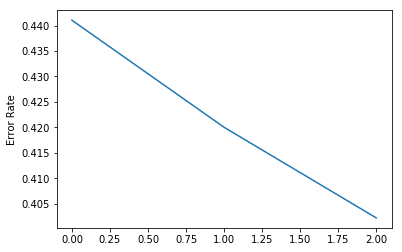

In [11]:
#Read training data
X_train, y_train, Query = readDataset('data/train.txt')
#Extract document pairs
pairs = extractPairsOfRatedSites(y_train, Query)
#Initialize Neural Network
rankNet = NN(10, 15, 0.001)
#Train the Neural Network
rankNet.train(X_train, pairs, 3)

In [12]:
y_pred = [rankNet.propagate(X[1].values[2:]) for X in df_train.iterrows()]

mean_ndcg(df_train.relevance.values, y_pred, df_train.qid.values)

0.5264243651913629

In [13]:
#Read testset
X_test, y_test, Query_test = readDataset('Data/test.txt')
#Extract document pairs
pairs_test = extractPairsOfRatedSites(y_test, Query_test)
print('Testset errorRate: ' + str(rankNet.countMisorderedPairs(X_test, pairs_test)))

Reading training data from file...
Read 2144 lines from file...
Found 18706 document pairs
Testset errorRate: 0.520207420079119


In [14]:
y_pred = [rankNet.propagate(X[1].values[2:]) for X in df_test.iterrows()]

mean_ndcg(df_test.relevance.values, y_pred, df_test.qid.values)

0.528229341614242

пример ранжирования для примера из тестовой выборки

In [23]:
X_for_one_query = df_test[df_test['qid'] == 10056]
X_for_one_query

,relevance,qid,tf,idf,length,bm25,pagerank,inlink,outlink,slash,urlLength,childPage
16,0,10056,0.174455,0,0.084561,0.000000,0.00,0.000000,0,0.264231,0.473684,0.172414
17,2,10056,0.143302,0,0.013133,0.778357,0.50,0.178571,0,1.000000,0.578947,0.655172
18,0,10056,0.009346,0,0.005135,0.000000,0.50,0.133929,0,0.001745,0.052632,0.000000
19,1,10056,0.065421,0,0.007693,0.330412,1.00,0.250000,0,0.135091,0.105263,0.034483
20,2,10056,0.161994,0,0.011761,0.813411,1.00,0.241071,0,0.172420,1.000000,1.000000
21,0,10056,0.000000,0,0.000000,0.000000,1.00,0.285714,0,0.000000,0.000000,0.000000
22,1,10056,0.046729,0,0.004389,0.000000,1.00,0.303571,0,0.252919,0.157895,0.000000
23,0,10056,0.012461,0,0.001101,0.000000,1.00,1.000000,0,0.000000,0.000000,0.000000
24,1,10056,0.049844,0,0.002593,0.000000,1.00,0.598214,0,0.000000,0.000000,0.000000
25,1,10056,0.155763,0,0.008202,0.000000,1.00,0.607143,0,0.000000,0.000000,0.000000


In [37]:
y_for_one_query_pred = [rankNet.propagate(X[1].values[2:]) for X in X_for_one_query.iterrows()]
ans = list(zip(range(10), 
         y_for_one_query_pred,
           X_for_one_query.relevance.values
          )
      )
ans

[(0, 0.4649368163908721, 0),
 (1, 0.47497972898367774, 2),
 (2, 0.4673481177431689, 0),
 (3, 0.47104379957037196, 1),
 (4, 0.46846691399670415, 2),
 (5, 0.46447251262317263, 0),
 (6, 0.4627180586894997, 1),
 (7, 0.47585383338232445, 0),
 (8, 0.47026025157983453, 1),
 (9, 0.4723581750419353, 1)]

In [38]:
np.argsort(y_for_one_query_pred)

array([12, 14,  6,  5,  0, 10, 15,  2, 13,  4,  8,  3,  9,  1,  7, 11],
      dtype=int32)

In [17]:
dcg([el[2] for el in sorted(ans, key=lambda x: x[1])[::-1]])

2.5

In [18]:
ndcg([el[2] for el in sorted(ans, key=lambda x: x[1])[::-1]])

0.6885288809404666